In [1]:
# check whether the parameter distribution of one parameter is correct

In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob, toml, sys, os

sys.path.append('../MOASMO_support')

from MOASMO_parameters import *

def gpr_emulator_cv(x, y, alpha, leng_lb, leng_ub, nu, xlb_mean, xub_mean, outpath, iterflag):

    random.seed(1234567890)
    np.random.seed(1234567890)

    n_splits = 5
    
    kf = KFold(n_splits=n_splits, shuffle=True) 
    kge_scores = np.nan * np.zeros([n_splits, y.shape[1]])

    y_pred_all = np.nan * np.zeros([x.shape[0], y.shape[1]])
    test_indices = []
    
    for fold_idx, (train_index, test_index) in enumerate(kf.split(x), 1):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Initialize and train your GPR model here; adjust parameters as needed
        sm = gp.GPR_Matern(x_train, y_train, x_train.shape[1], y_train.shape[1], x_train.shape[0], xlb_mean, xub_mean, alpha=alpha, leng_sb=[leng_lb, leng_ub], nu=nu)
        
        # Predict using the trained model
        y_pred = sm.predict(x_test)  # Adjust this method call based on your model's API
        
        # Evaluate the model using KGE
        for i in range(y.shape[1]):
            kge_scores[fold_idx-1, i] = get_modified_KGE(y_test[:,i], y_pred[:,i])

        y_pred_all[test_index, :] = y_pred
        test_indices.append(test_index)
    
    # Calculate the mean KGE score across all folds
    mean_kge_score = np.nanmean(kge_scores, axis=0)[np.newaxis, :]
    kge_scores = np.concatenate([kge_scores, mean_kge_score])

    # Convert the list of KGE scores into a pandas DataFrame
    kge_scores_df = pd.DataFrame()
    kge_scores_df['Fold'] = list(np.arange(n_splits)+1) + ['mean']
    kge_scores_df['kge1'] = kge_scores[:, 0]
    kge_scores_df['kge2'] = kge_scores[:, 1]
    kge_scores_df['kge_mean'] = (kge_scores[:, 0] + kge_scores[:, 1])/2
    
    print("GPR CV KGE Score for metric1/metric2:")
    print(kge_scores_df)
    
    csv_file_path =  f'{outpath}/GPR_for_iter{iterflag}_CV_kge.csv'
    kge_scores_df.to_csv(csv_file_path, index=False)

    return kge_scores_df, y_pred_all, test_indices


def rf_emulator_cv(x, y, outpath, iterflag):

    random.seed(1234567890)
    np.random.seed(1234567890)
    
    n_splits = 5
    
    kf = KFold(n_splits=n_splits, shuffle=True) 
    kge_scores = np.nan * np.zeros([n_splits, y.shape[1]])

    y_pred_all = np.nan * np.zeros([x.shape[0], y.shape[1]])
    test_indices = []
    
    for fold_idx, (train_index, test_index) in enumerate(kf.split(x), 1):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Initialize and train your GPR model here; adjust parameters as needed
        sm = RandomForestRegressor()
        sm.fit(x_train, y_train)
        
        # Predict using the trained model
        y_pred = sm.predict(x_test)  # Adjust this method call based on your model's API
        
        # Evaluate the model using KGE
        for i in range(y.shape[1]):
            kge_scores[fold_idx-1, i] = get_modified_KGE(y_test[:,i], y_pred[:,i])

        y_pred_all[test_index, :] = y_pred
        test_indices.append(test_index)
    
    # Calculate the mean KGE score across all folds
    mean_kge_score = np.nanmean(kge_scores, axis=0)[np.newaxis, :]
    kge_scores = np.concatenate([kge_scores, mean_kge_score])

    # Convert the list of KGE scores into a pandas DataFrame
    kge_scores_df = pd.DataFrame()
    kge_scores_df['Fold'] = list(np.arange(n_splits)+1) + ['mean']
    kge_scores_df['kge1'] = kge_scores[:, 0]
    kge_scores_df['kge2'] = kge_scores[:, 1]
    kge_scores_df['kge_mean'] = (kge_scores[:, 0] + kge_scores[:, 1])/2
    
    print("RF CV KGE Score for metric1/metric2:")
    print(kge_scores_df)
    
    csv_file_path =  f'{outpath}/RF_for_iter{iterflag}_CV_kge.csv'
    kge_scores_df.to_csv(csv_file_path, index=False)

    return kge_scores_df, y_pred_all, test_indices




# load basin iter-0 outputs

In [3]:
# b = 145
b = 174

df_param = pd.read_csv(f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{b}_MOASMOcalib/ctsm_outputs/iter0_all_meanparam.csv')
df_metric = pd.read_csv(f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{b}_MOASMOcalib/ctsm_outputs/iter0_all_metric.csv')
df_info = pd.read_pickle(f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{b}_MOASMOcalib/param_sets/all_default_parameters.pkl')

param_defa = df_info['Default'].values
param_lower = df_info['Lower'].values
param_upper = df_info['Upper'].values
param_name = df_info['Parameter'].values

param_iter0 = df_param.values
nparam = len(param_upper)

print(param_iter0.shape)

(400, 15)


# original RF/GPR CV outputs (fixed random seeed)

In [4]:
        outpath = '/glade/derecho/scratch/guoqiang/test'
        iterflag = 0
        # define hyper parameters
        pop = 100
        gen = 100
        crossover_rate = 0.9
        mu = 20
        mum = 20

        # define hyperparameter
        alpha = 1e-3
        leng_lb = 1e-3
        leng_ub = 1e3
        nu = 2.5


        param_names = df_info['Parameter'].values # exclude binded parameters
        df_param = df_param[param_names]

        xlb_mean = np.array([np.nanmean(v) for v in df_info['Lower']])
        xub_mean = np.array([np.nanmean(v) for v in df_info['Upper']])

        x = df_param.to_numpy()
        y = df_metric.to_numpy()

        ind = ~np.isnan( np.sum(x,axis=1) + np.sum(y,axis=1))
        x, y = x[ind, :], y[ind, :]

        nInput = x.shape[1]
        nOutput = y.shape[1]


        # decide the most suitable emulator based on cross validation
        os.makedirs(outpath, exist_ok=True)
        gpr_kge_cv, y_pred_gpr, test_indices_gpr = gpr_emulator_cv(x, y, alpha, leng_lb, leng_ub, nu, xlb_mean, xub_mean, outpath, iterflag)
        rf_kge_cv, y_pred_rf, test_indices_rf = rf_emulator_cv(x, y, outpath, iterflag)



GPR CV KGE Score for metric1/metric2:
   Fold      kge1       kge2  kge_mean
0     1  0.803928 -20.643295 -9.919684
1     2  0.754379   0.519274  0.636826
2     3  0.774839   0.450716  0.612777
3     4  0.744384   0.532555  0.638469
4     5  0.835863   0.481112  0.658488
5  mean  0.782679  -3.731928 -1.474625
RF CV KGE Score for metric1/metric2:
   Fold      kge1      kge2  kge_mean
0     1  0.360286  0.287336  0.323811
1     2  0.357596  0.303823  0.330709
2     3  0.349820  0.325795  0.337808
3     4  0.380090  0.327883  0.353986
4     5  0.375931  0.257513  0.316722
5  mean  0.364745  0.300470  0.332607


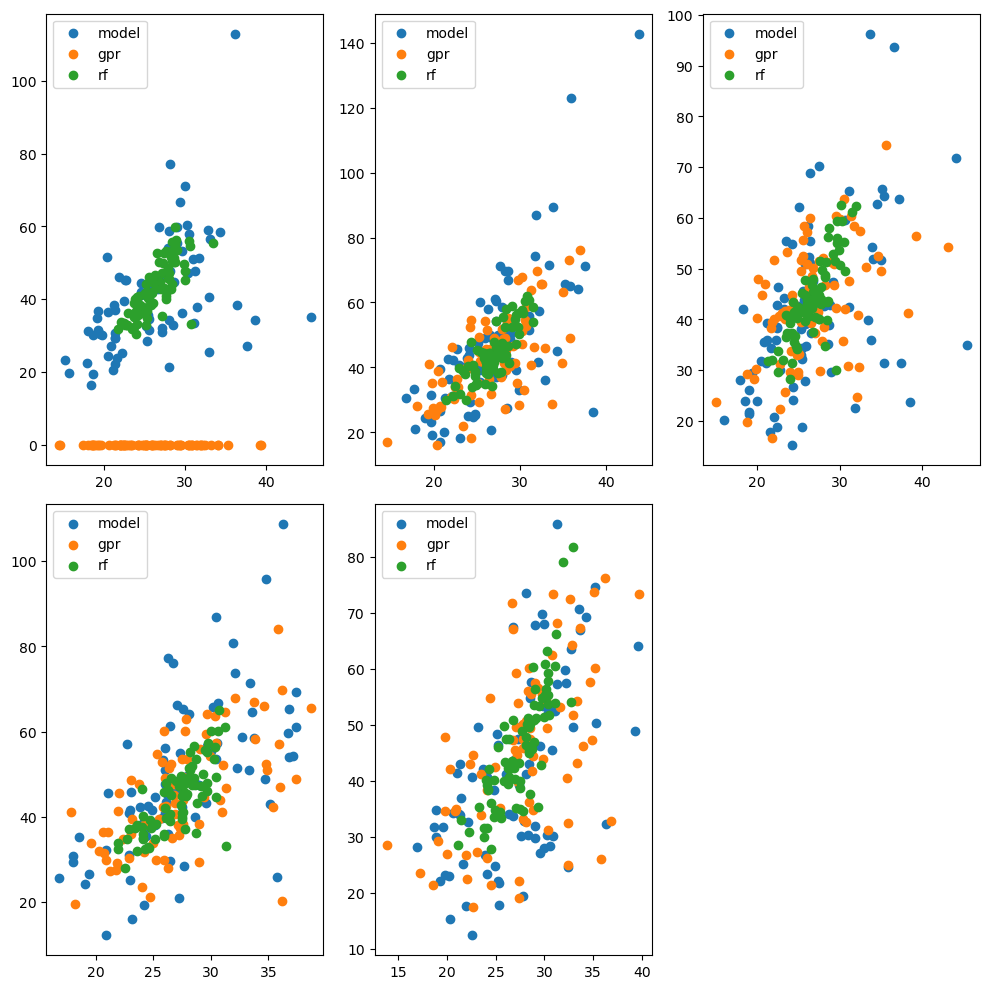

In [5]:
# relationship between metric-1 and metric-2 according to different sources

fig = plt.figure(figsize=[10,10])


for i in range(5):
    fig.add_subplot(2,3,i+1)
    plt.scatter(y[test_indices_gpr[i], 0], y[test_indices_gpr[i], 1], label='model')
    plt.scatter(y_pred_gpr[test_indices_gpr[i], 0], y_pred_gpr[test_indices_gpr[i], 1], label='gpr')
    plt.scatter(y_pred_rf[test_indices_rf[i], 0], y_pred_rf[test_indices_rf[i], 1], label='rf')
    plt.legend()

plt.tight_layout()
plt.show()

# Run CV GPR again but output CV estimates and plot

In [18]:
# x2 = x.copy()
# for i in range(x2.shape[1]):
#     di = x2[:,i]
#     if np.any(di==xlb_mean[i]):
#         di[di==xlb_mean[i]] = xlb_mean[i] * 1.01
#         print('lb adjust')
#     if np.any(np.any(di==xub_mean[i])):
#         di[di==xub_mean[i]] = xub_mean[i] * 0.99
#         print('ub adjust')
#     x2[:,i] = di

# x = x2

In [25]:
    # random.seed(1234567890)
    # np.random.seed(1234567890)

    n_splits = 5
    
    kf = KFold(n_splits=n_splits, shuffle=True) 
    kge_scores = np.nan * np.zeros([n_splits, y.shape[1]])

    y_pred_all = np.nan * np.zeros([x.shape[0], y.shape[1]])
    test_indices = []
    
    for fold_idx, (train_index, test_index) in enumerate(kf.split(x), 1):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Initialize and train your GPR model here; adjust parameters as needed
        sm = gp.GPR_Matern(x_train, y_train, x_train.shape[1], y_train.shape[1], x_train.shape[0], xlb_mean, xub_mean, alpha=alpha, leng_sb=[leng_lb, leng_ub], nu=nu)
        
        # Predict using the trained model
        y_pred = sm.predict(x_test)  # Adjust this method call based on your model's API
        
        # Evaluate the model using KGE
        for i in range(y.shape[1]):
            kge_scores[fold_idx-1, i] = get_modified_KGE(y_test[:,i], y_pred[:,i])

        y_pred_all[test_index, :] = y_pred
        test_indices.append(test_index)

    # Calculate the mean KGE score across all folds
    mean_kge_score = np.nanmean(kge_scores, axis=0)[np.newaxis, :]
    kge_scores = np.concatenate([kge_scores, mean_kge_score])

    # Convert the list of KGE scores into a pandas DataFrame
    kge_scores_df = pd.DataFrame()
    kge_scores_df['Fold'] = list(np.arange(n_splits)+1) + ['mean']
    kge_scores_df['kge1'] = kge_scores[:, 0]
    kge_scores_df['kge2'] = kge_scores[:, 1]
    kge_scores_df['kge_mean'] = (kge_scores[:, 0] + kge_scores[:, 1])/2
    
    print("RF CV KGE Score for metric1/metric2:")
    print(kge_scores_df)
    

RF CV KGE Score for metric1/metric2:
   Fold      kge1      kge2  kge_mean
0     1  0.838643  0.570886  0.704764
1     2  0.693624  0.491757  0.592690
2     3  0.791197  0.469920  0.630559
3     4  0.749659  0.534336  0.641997
4     5  0.752623  0.499801  0.626212
5  mean  0.765150  0.513340  0.639245


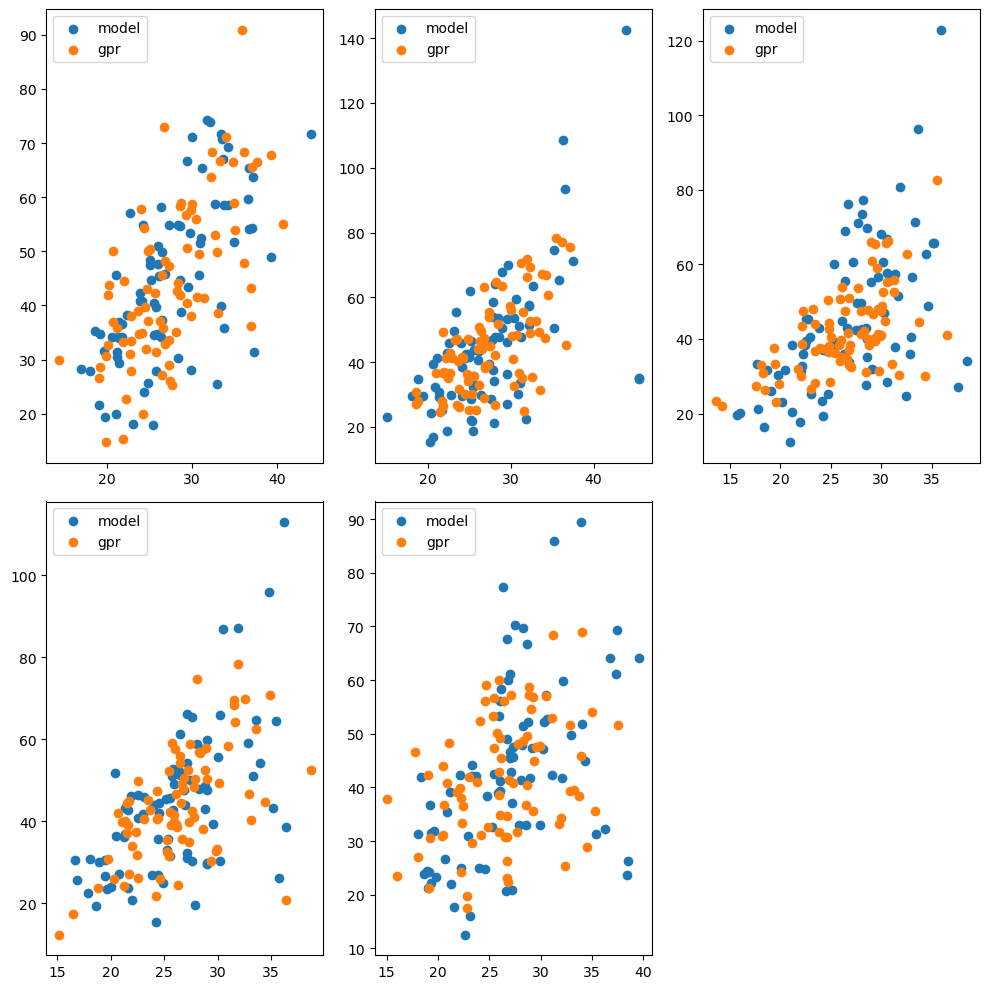

In [26]:
fig = plt.figure(figsize=[10,10])

for i in range(5):
    fig.add_subplot(2,3,i+1)
    plt.scatter(y[test_indices[i], 0], y[test_indices[i], 1], label='model')
    plt.scatter(y_pred_all[test_indices[i], 0], y_pred_all[test_indices[i], 1], label='gpr')
    plt.legend()

plt.tight_layout()
plt.show()

# still CV but use Sklearn GPR

In [9]:
    # try sklearn gpr
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern
    from sklearn.model_selection import KFold
    import numpy as np

    # random.seed(123456789)
    # np.random.seed(123456789)

    n_splits = 5

    kf = KFold(n_splits=n_splits, shuffle=True)
    kge_scores = np.nan * np.zeros([n_splits, y.shape[1]])

    y_pred_all = np.nan * np.zeros([x.shape[0], y.shape[1]])
    test_indices = []

    for fold_idx, (train_index, test_index) in enumerate(kf.split(x), 1):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Normalize features
        scaler = MinMaxScaler().fit(x_train)
        X_train_scaled = scaler.transform(x_train)
        X_test_scaled = scaler.transform(x_test)

        # Initialize the GPR model
        kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-3, 1000.0), nu=1.5)
        model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True, random_state=42)
        model.fit(X_train_scaled, y_train)  # Fit the model on the training data
        y_pred = model.predict(X_test_scaled)  # Predict on the test set

        # Evaluate the model using KGE
        for i in range(y.shape[1]):
            kge_scores[fold_idx - 1, i] = get_modified_KGE(y_test[:, i], y_pred[:, i])

        y_pred_all[test_index, :] = y_pred
        test_indices.append(test_index)

    # Calculate the mean KGE score across all folds
    mean_kge_score = np.nanmean(kge_scores, axis=0)[np.newaxis, :]
    kge_scores = np.concatenate([kge_scores, mean_kge_score])

    # Convert the list of KGE scores into a pandas DataFrame
    kge_scores_df = pd.DataFrame()
    kge_scores_df['Fold'] = list(np.arange(n_splits) + 1) + ['mean']
    kge_scores_df['kge1'] = kge_scores[:, 0]
    kge_scores_df['kge2'] = kge_scores[:, 1]
    kge_scores_df['kge_mean'] = (kge_scores[:, 0] + kge_scores[:, 1]) / 2

    print("RF CV KGE Score for metric1/metric2:")
    print(kge_scores_df)


RF CV KGE Score for metric1/metric2:
   Fold      kge1      kge2  kge_mean
0     1  0.664731  0.462008  0.563369
1     2  0.700221  0.390402  0.545312
2     3  0.607473  0.484446  0.545960
3     4  0.673008  0.395864  0.534436
4     5  0.677953  0.474129  0.576041
5  mean  0.664677  0.441370  0.553023


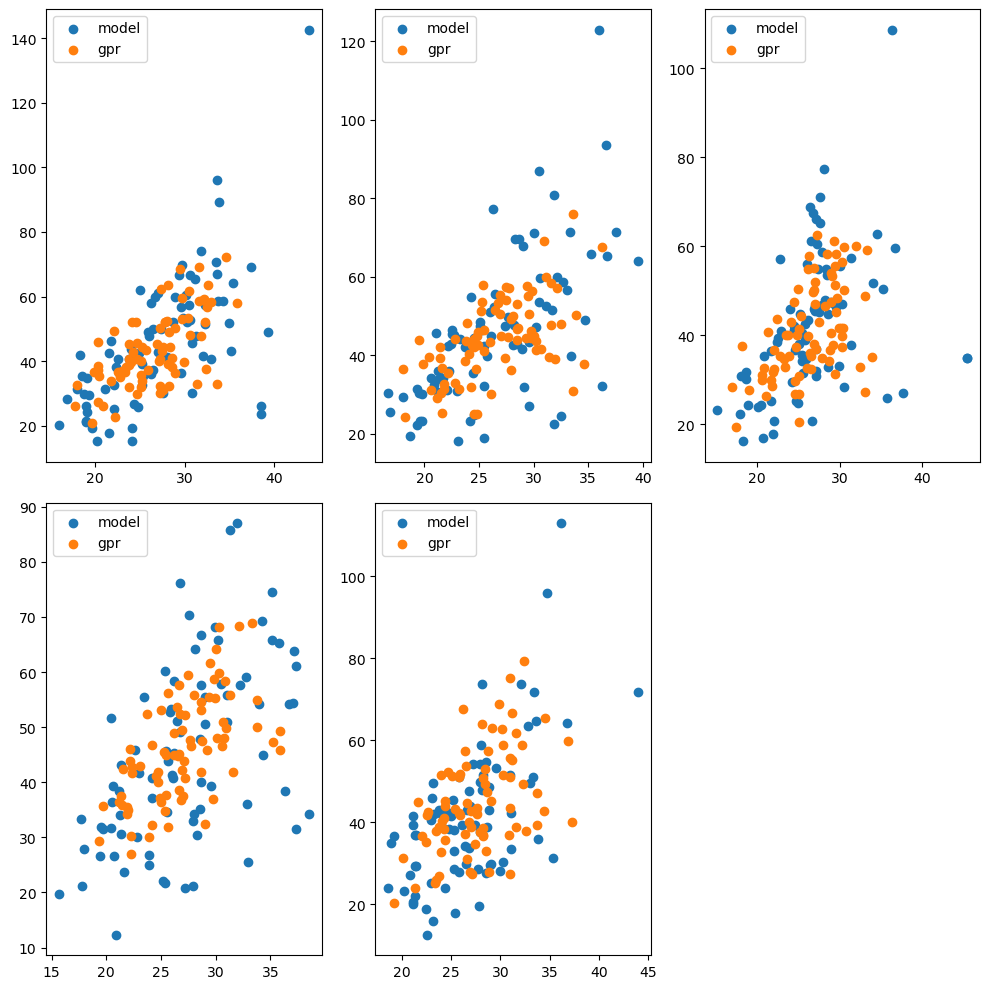

In [10]:
fig = plt.figure(figsize=[10,10])

for i in range(5):
    fig.add_subplot(2,3,i+1)
    plt.scatter(y[test_indices[i], 0], y[test_indices[i], 1], label='model')
    plt.scatter(y_pred_all[test_indices[i], 0], y_pred_all[test_indices[i], 1], label='gpr')
    plt.legend()

plt.tight_layout()
plt.show()

In [39]:
len(gpr_kge_cv)

6